# Cole et al. (2023): Sensitivity Analysis for Missing Data

Cole et al. (2023) reviewed a sensitivity analysis method for missing data proposed in Robins et al. (1999). This example was illustrated using simulated missing data on CD4 T cell counts among persons with HIV (an immune marker for disease progression). In the paper, the estimator and corresponding estimating functions are reviewed. The data is available [here](https://github.com/pzivich/publications-code/tree/master/RobinsSensitivityAnalysis).

Here, we will replicate this example using `delicatessen`. 

## Setup

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import delicatessen as deli
from delicatessen import MEstimator
from delicatessen.estimating_equations import ee_regression, ee_mean_sensitivity_analysis
from delicatessen.utilities import inverse_logit, logit

print("Versions")
print("NumPy:       ", np.__version__)
print("SciPy:       ", sp.__version__)
print("pandas:      ", pd.__version__)
print("Matplotlib:  ", mpl.__version__)
print("Delicatessen:", deli.__version__)

Versions
NumPy:        2.3.5
SciPy:        1.16.3
pandas:       2.3.3
Matplotlib:   3.10.8
Delicatessen: 4.1


In [2]:
d = pd.read_csv("data/lau_wihs.dat", sep=r"\s+", 
                header=None, 
                names=["id", "black", "age", "cd4", "cd41", "cd42", "cd43", "cd44"])
d['cd41'] = pd.to_numeric(d['cd41'], errors='coerce')
d['cd42'] = pd.to_numeric(d['cd42'], errors='coerce')
d['cd43'] = pd.to_numeric(d['cd43'], errors='coerce')
d['cd44'] = pd.to_numeric(d['cd44'], errors='coerce')

Note that the last 3 columns are all variations on the extent of the missing data

## Complete-Case Analysis

As a starting point, consider if we did a complete-case analysis for the second scenario

In [3]:
y = np.asarray(d['cd42'])
r = np.where(np.isnan(y), 0, 1)

In [4]:
def psi_mean(theta):
    return r*(np.nan_to_num(y, nan=-999) - theta)

In [5]:
estr = MEstimator(psi_mean, init=[300., ])
estr.estimate()

In [6]:
print('mu:    ', estr.theta[0])
print('95% CI:', estr.confidence_intervals()[0])

mu:     464.64812712826335
95% CI: [447.67347732 481.62277694]


However, this complete-case analysis assumes missing data is non-informative (or 'missing completely at random'). We might be suspicious that this is the case. This is where the sensitivity analysis comes in.

## Sensitivity Analysis

This approach is based on the following expression
$$ \mu = E \left[ \frac{R_i Y_i}{H[\beta + q(Y; \alpha)]} \right] $$
where $Y$ is CD4, $R$ indicates whether $Y$ was observed, $H$ is a user-specified monotonic increasing function with outputs bounded between zero and one, and $q$ is a user-specified bias function (that can depend on $Y$ itself). Here, $\alpha$ is not estimable (the problem of an unknown missing data mechanism). However, we can plug-in different values for $\alpha$ and see how that changes our results. Further, we might even have a best guess at a range for $\alpha$. Here, $\beta$ is a bounding paramter that we will estimate. 

For the following example, $H$ is specified to be the logistic function. We will also use the following $q(Y; \alpha)$ function
$$ q(Y; \alpha) = \alpha Y $$
which can be programmed as the following

In [7]:
def q_function(y_vals, alpha):
    return alpha*np.where(np.isnan(y_vals), 0, y_vals)

Having defined the general $q$ function, we can now setup the corresponding estimating functions. The first defined is for our parameter of interest 
$$ \psi(O_i; F_Y(y)) = \frac{R_i I(Y_i \le y)}{H[\beta + q(Y; \alpha)]} - F_Y(y) $$ 
This estimating function depends on $\beta$, which can be estimated via
$$ \psi(O_i; \beta) = \frac{R_i}{H[\beta + q(Y; \alpha)]} - 1 $$ 
thus we can stack these together. The following code sets up these estimating functions

In [8]:
def psi_sens(theta):
    mu_y = theta[0]
    beta = theta[1]
    
    # Solving for the sensitivity analysis mean
    numerator = r * y                                # Numerator
    denominator = inverse_logit(beta + qy)           # Denominator
    mean = np.nan_to_num(numerator / denominator,    # Sensitivity analysis
                         copy=False, nan=0.) - mu_y  # ... and setting missing as zero's

    # Solving for intercept of model
    h_params = (r / inverse_logit(beta + qy) - 1)
    
    # Returning stacked estimating equations
    return np.vstack((mean, h_params))

As stated before, $\alpha$ cannot be estimated with the full-data. Instead, we can plug in different values for $\alpha$ and see how the results change. To begin, let's look at $\alpha := 0.01$. With that, we can apply the $q$ function.

In [9]:
alpha = 0.01
qy = q_function(y_vals=y, alpha=alpha)

Now we are prepared to call the M-estimator

In [10]:
init_vals = [300., 0.]
estr = MEstimator(psi_sens, init=init_vals)
estr.estimate()

In [11]:
print("mu:    ", estr.theta[0])
print("95% CI:", estr.confidence_intervals()[0, :])

mu:     397.07319888968004
95% CI: [381.08390241 413.06249537]


This is notably lower than the complete-case analysis. 

We can also implement this approach using the built-in `ee_mean_sensitivity_analysis` function. The following illustrates its use

In [12]:
def psi_robins(theta):
    return ee_mean_sensitivity_analysis(theta=theta, 
                                        y=y, 
                                        delta=r, 
                                        X=1, 
                                        q_eval=qy, 
                                        H_function=inverse_logit)

In [13]:
init_vals = [300., 0.]
estr = MEstimator(psi_robins, init=init_vals)
estr.estimate()

print("mu:    ", estr.theta[0])
print("95% CI:", estr.confidence_intervals()[0, :])

mu:     397.07319888968004
95% CI: [381.08390241 413.06249537]


which is the same result as previously (as is expected).

However, these prior results are only for a single value of $\alpha$. There isn't a strong reason to believe that the true $\alpha$ is actually $0.01$. Instead, we should look over a range of values for $\alpha$. This is also where M-estimation shines. Without M-estimation, we would need to bootstrap to appropriately estimate the variance. This can be computationally intensive when we can to explore a large grid of values for $\alpha$.

The following code explores the sensitivity analysis over a grid of values for $\alpha$ and then plots them. Note that the root-finding procedure can be difficult at more 'extreme' values of $\alpha$. To get around this, we start at $\alpha :=0$ and then build out the estimates from there.

In [14]:
alpha_l = np.linspace(0.0, -0.04, 100)
alpha_u = np.linspace(0.0, 0.04, 100)
point, lcl, ucl = [], [], []

for alphas in [alpha_l, alpha_u]:
    init_vals = [400., 0.]
    for alpha in alphas:
        # Updating q-function values
        qy = q_function(y_vals=y, alpha=alpha)
    
        # Applying M-estimator
        estr = MEstimator(psi_robins, init=init_vals)
        estr.estimate()
        ci = estr.confidence_intervals()[0, :]
    
        # Extracting output
        point.append(estr.theta[0])
        lcl.append(ci[0])
        ucl.append(ci[1])
    
        # Update init to speed up root-finding in next iteration
        init_vals = estr.theta
    

In [15]:
p = pd.DataFrame()
p['alpha'] = list(alpha_l) + list(alpha_u)
p['point'] = point
p['lcl'] = lcl
p['ucl'] = ucl
p = p.sort_values(by='alpha')

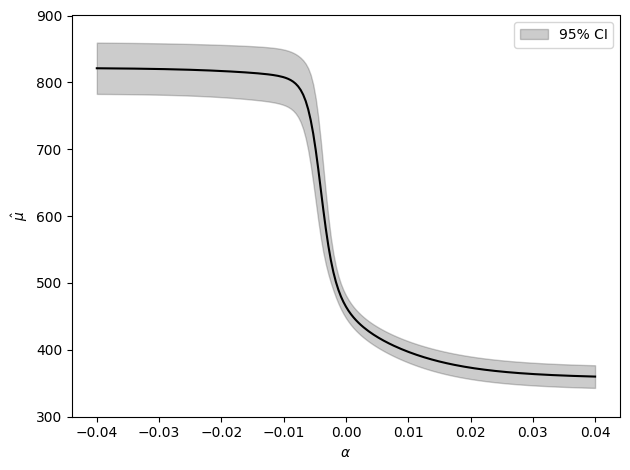

In [16]:
plt.fill_between(p['alpha'], p['lcl'], p['ucl'], color='k', alpha=0.2, label='95% CI')
plt.plot(p['alpha'], p['point'], '-', color='k')
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\hat{\mu}$")
plt.legend(loc='upper right')
plt.ylim([300, 900])
plt.tight_layout()

Estimating $\mu$ across this grid of $\alpha$ takes a few seconds at most. This is dramatically faster than if we were too bootstrap. This again highlights the power of M-estimation and the sandwich variance. 

As we can see in the plot, it looks like the parameters asymptote at certain values. This is indeed the case. This sensitivity analysis returns the nonparametric bounds in the limit. We can also easily compute the boundary points with M-estimation

## Bounds

For the mean of a continuous variable, the bounds make the extreme assumption that everyone has the highest (lowest) observed $Y$ value to compute the upper (lower) bound on $\mu$. This is relatively easy to program by adapting the complete-case analysis code, like the following

In [17]:
def psi_bounds(theta):
    ee_lower = np.nan_to_num(y, nan=np.nanmin(y)) - theta[0]
    ee_upper = np.nan_to_num(y, nan=np.nanmax(y)) - theta[1]
    return np.vstack([ee_lower, ee_upper])

In [18]:
init_vals = [400., 700.]
estr = MEstimator(psi_bounds, init=init_vals)
estr.estimate()
ci = estr.confidence_intervals()

print("Bounds:", estr.theta)
print("95% CI:", ci[0, 0], ci[1, 1])

Bounds: [354.35395189 821.6443299 ]
95% CI: 337.32317257726663 860.0407261937755


These are the nonparametric bounds for missingness of the mean. However, note that these bounds do assume that the maximum possible value of $Y$ for the missing observations is the maximum in the observed data. We can avoid this assumption by replacing the maximum (minimum) with larger (smaller) values if we are concerned about this assumption.

So, this example shows how `delicatessen` can be used for sensitivity analyses. It also further highlights the advantage of the sandwich variance for computational purposes. It allowed up to explore a range of sensitivity analyses while remaining computationally quick.

## References

Cole, S. R., Zivich, P. N., Edwards, J. K., Shook-Sa, B. E., & Hudgens, M. G. (2023). Sensitivity analyses for means or proportions with missing outcome data. *Epidemiology*, 34(5), 645-651.

Robins, J. M., Rotnitzky, A., & Scharfstein, D. O. (2000). Sensitivity analysis for selection bias and unmeasured confounding in missing data and causal inference models. In *Statistical models in epidemiology, the environment, and clinical trials* (pp. 1-94). New York, NY: Springer New York.